# CRO: Dealing with imbalance data (Logistic Regression and Decision Tree)
    Ruixie Fang
    
### Goal

Optimizing conversion rate is likely the most common work of a data scientist, and rightfully so.

The data revolution has a lot to do with the fact that now we are able to collect all sorts of data about people who buy something on our site as well as people who don't. This gives us a tremendous opportunity to understand what's working well (and potentially scale it even further) and what's not working well (and ﬁx it).

The goal of this challenge is to build a model that predicts conversion rate and, based on the model, come up with ideas to improve re]enue.


### Challenge Description

We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

Your project is to:

   - Predict conversion rate

   - Come up with recommendations for the product team and the marketing team to improve conversion rate.

### Columns:

- country : user country based on the IP address 
- age : user age. Self-reported at sign-in step 
- new_user : whether the user created the account during this session or had already an account and simply came back to the site 
- source : marketing channel source:
    - Ads: came to the site by clicking on an advertisement
    - Seo: came to the site by clicking on search results
    - Direct: came to the site by directly typing the URL on the browser 
- total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
- converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. The company goal is to increase conversion rate: # conversions / total sessions.

In [64]:
# Analysis imports
import numpy as np
import pandas as pd

# Visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,roc_auc_score

import collections

# Miscellaneous imports
import warnings
warnings.simplefilter('ignore')

## Import data and Basic Descriptive Analysis
- Variable Types / Missing value/ Outliers.

In [3]:
df = pd.read_csv("conversion_project.csv")
df.sample(10)

,country,age,new_user,source,total_pages_visited,converted
30427,China,23,1,Seo,3,0
10899,US,21,0,Ads,2,0
239295,US,25,1,Ads,5,0
81235,US,55,1,Direct,4,0
273104,US,28,0,Seo,6,0
249509,US,26,1,Ads,1,0
149158,US,22,1,Seo,3,0
289961,China,35,0,Seo,4,0
92625,China,38,1,Ads,17,0
209994,Germany,29,1,Ads,6,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [5]:
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


**Categorical**: country, converted, new_user, source.   \
**Continous**: Age,total_pages_visited. \
Two features are strings (object), others are numeric.

In [6]:
#Check Missing values
print('Columns with null values:\n', df.isnull().sum())

Columns with null values:
 country                0
age                    0
new_user               0
source                 0
total_pages_visited    0
converted              0
dtype: int64


In [7]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


**The distribution of numerical feature values across 316200 samples:**
- Most visitors' age are around 22-38.
- 69% of visitors are new users. 
- Total_pages_visited per visitor is around 4-5.
- The conversion rate=3.23% indicates that visitors are hard to convert into customers.


In [8]:
counts = df.converted.value_counts()
Cov = counts[0]
NotCov = counts[1]
perc_Cov = (Cov/(Cov+NotCov))*100
perc_NotCov = (NotCov/(Cov+NotCov))*100
print('There were {} Not-Converted ({:.2f}%) and {} Converted ({:.2f}%).'.format(Cov, perc_Cov, NotCov, perc_NotCov))

There were 306000 Not-Converted (96.77%) and 10200 Converted (3.23%).


Text(0.5, 1.0, 'Class Distributions \n (0: Not Converted || 1: Converted)')

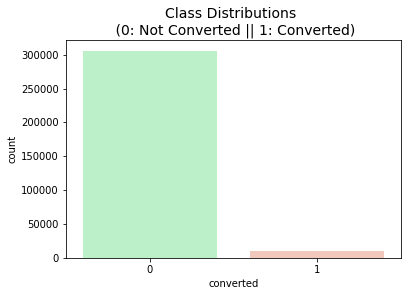

In [9]:
colors = ['#B3F9C5', '#f9c5b3']

sns.countplot('converted', data=df, palette=colors)
plt.title('Class Distributions \n (0: Not Converted || 1: Converted)', fontsize=14)

### Outlier Detection and Removal
Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.

**Boxplots:** Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme).

Text(0.5, 1.0, 'Age Feature \n Reduction of outliers')

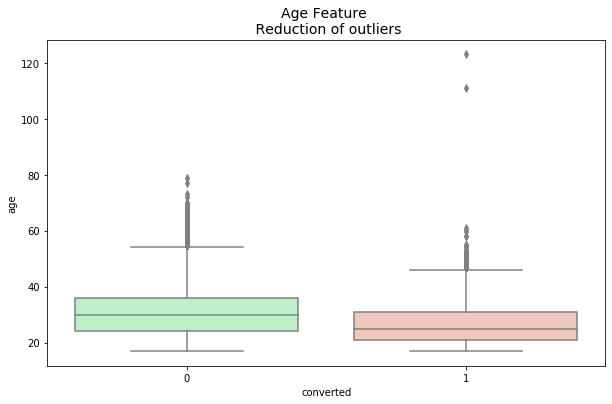

In [10]:
f,(ax1) = plt.subplots(1, 1, figsize=(10,6))

# Boxplots with outliers removed
# Feature "Age"
sns.boxplot(x="converted", y="age", data=df,ax=ax1, palette=colors)
ax1.set_title("Age Feature \n Reduction of outliers", fontsize=14)

Typically, age should be below 100. These two obvious point(>100) can be identified as outliers and removed.

In [11]:
df[df['age'] > 100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


In [12]:
# Remove outliers
df = df[df.age < 100]

## Exploratory Data Analysis
- Feature Analysis : Country / User Type / Total Pages visited / Sources /Ages

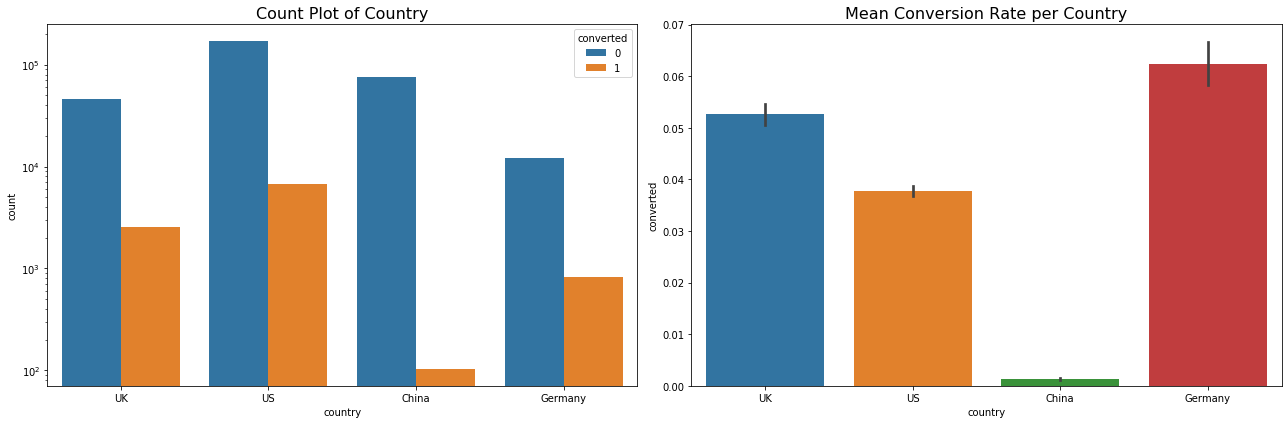

In [13]:
# Visualization of different countries
grouped = df[['country', 'converted']].groupby('country').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='country', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of Country', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='country', y='converted', data=df, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Country', fontsize=16)
plt.tight_layout()
plt.show()

**Assumption based on country:**
- The overall rate of Conversion = 0 is greater than conversion = 1.
- Most visitors are from US.
- German has less visitors but highest conversion rate.
- China has 2nd rank of visitors number but with extreme low conversion rate. 

It might be a reason that affect visitors. Website language for product description may be all English. \
Since China is a large population country. Improving Chinese visitors' user experience, it might be a good strategy to increase conversion rate.

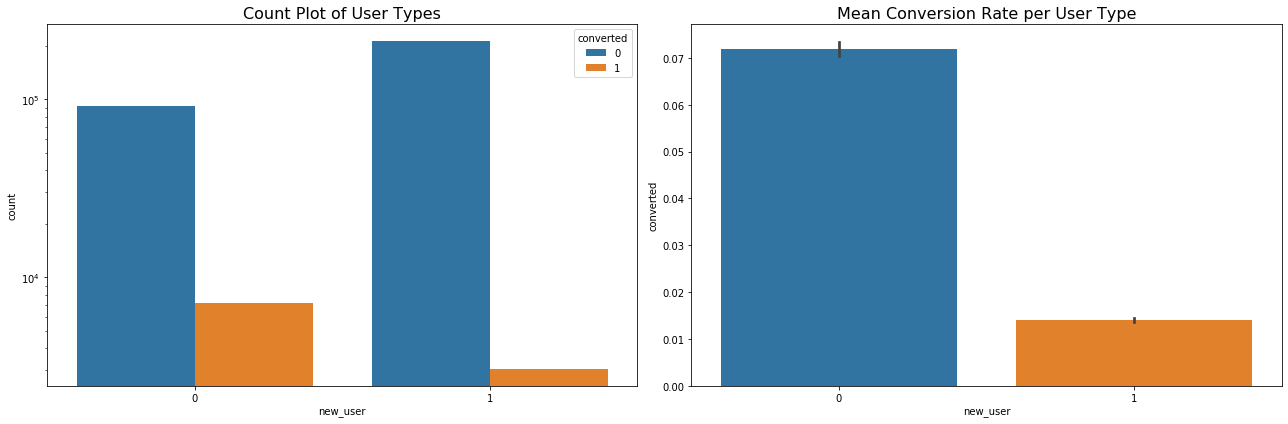

In [290]:
# Visualization of different user types
grouped = df[['new_user', 'converted']].groupby('new_user').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='new_user', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of User Types', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='new_user', y='converted', data=df, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per User Type', fontsize=16)
plt.tight_layout()
plt.show()

**Assumption based on user type:**  \
The mean conversion rate of old-users is almost 75.7% than that of new-users. 

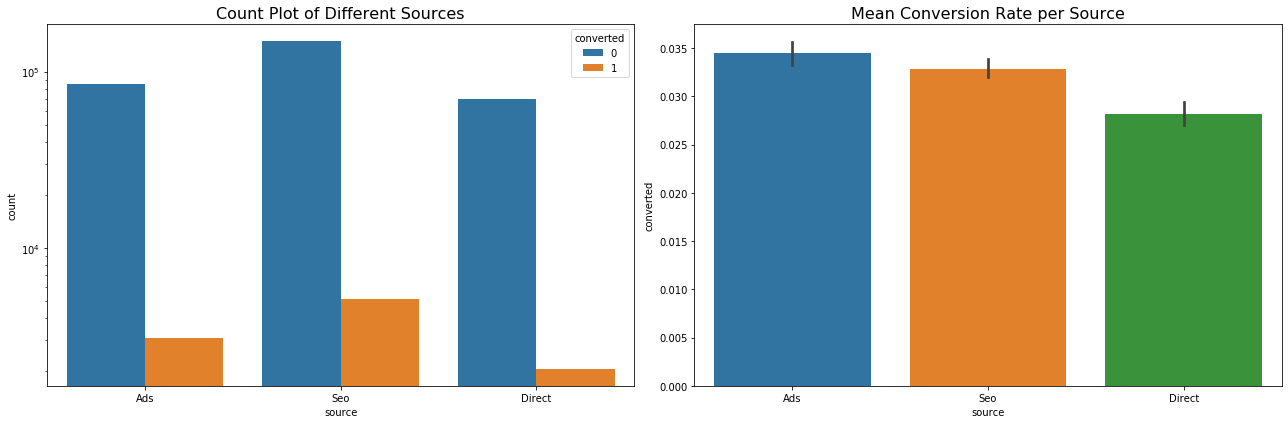

In [291]:
# Visualization of different sources
grouped = df[['source', 'converted']].groupby('source').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='source', hue='converted', data=df, ax=ax[0])
ax[0].set_title('Count Plot of Different Sources', fontsize=16)
ax[0].set_yscale('log')
sns.barplot(x='source', y='converted', data=df, ax=ax[1]);
ax[1].set_title('Mean Conversion Rate per Source', fontsize=16)
plt.tight_layout()
plt.show()

**Assumption based on sources:**   

    Ads: came to the site by clicking on an advertisement
    Seo: came to the site by clicking on search results
    Direct: came to the site by directly typing the URL on the browser  
- The advertisement can be a powerful campaign to attract visitors.
- Visitors from search source has the highest conversion rate. They have more motivation to purchase since they have a purpose in knowing about the product.

**Distributions:** By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

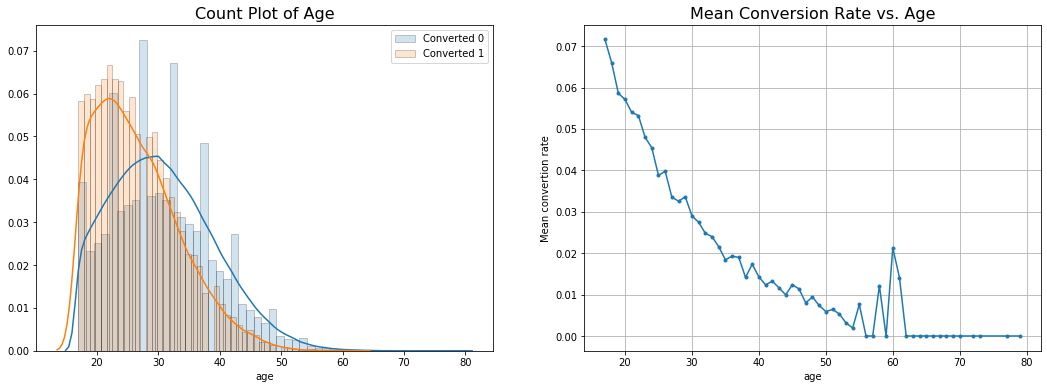

In [292]:
# Visualization of different age
grouped = df[['age', 'converted']].groupby('age').mean().reset_index()
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df[df['converted'] == 0]['age'], label='Converted 0', 
             ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['converted'] == 1]['age'], label='Converted 1', 
             ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['age'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Age', fontsize=16)
ax[1].set_xlabel('age')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

**Assumption based on age:**
- Most visitors' age are around 22-38 and all visitors age>65 are not convert into customer. 
- Negative relasionship between age and conversion rate. Normally younger people have higher purchase demand than older person.
- Especially visitors' age from 18-32 has higher conversion rate. The reason might be that the product suits younger people's need more.

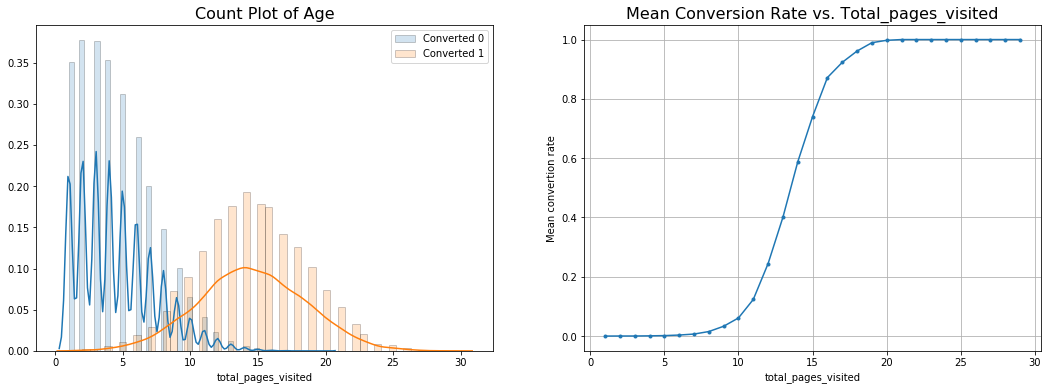

In [293]:
# Visualization of total_pages_visited
grouped = df[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(df[df['converted'] == 0]['total_pages_visited'], 
             label='Converted 0', ax=ax[0], hist_kws=hist_kws)
sns.distplot(df[df['converted'] == 1]['total_pages_visited'], 
             label='Converted 1', ax=ax[0], hist_kws=hist_kws)
ax[0].set_title('Count Plot of Age', fontsize=16)
ax[0].legend()
ax[1].plot(grouped['total_pages_visited'], grouped['converted'], '.-')
ax[1].set_title('Mean Conversion Rate vs. Total_pages_visited', fontsize=16)
ax[1].set_xlabel('total_pages_visited')
ax[1].set_ylabel('Mean convertion rate')
ax[1].grid(True)
plt.show()

There is a positive regression relationship between total_pages_visited and converted mean. The visitor with greater visites pages has higher potential to convert into customer.

### dummy coding

In [14]:
#Convert the categorical values to ordinal.
#That categorical data is defined as variables with a finite set of label values. 
#That most machine learning algorithms require numerical input and output variables. 
#That an integer and one hot encoding is used to convert categorical data to integer data.

#dummy coding
# Create dummy variables for country values
dfd=df.copy()
country_dummies = pd.get_dummies(dfd.country, prefix='country')
dfd = pd.concat([dfd, country_dummies], axis=1)
# Create dummy variables for source values
source_dummies = pd.get_dummies(dfd.source, prefix='source')
dfd = pd.concat([dfd, source_dummies], axis=1)
dfd.drop(["country", "source"], axis=1, inplace=True)
dfd.sample(10)

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
294466,37,0,6,0,0,0,1,0,1,0,0
43665,29,1,6,0,0,0,0,1,0,0,1
107497,24,0,6,0,0,0,0,1,0,0,1
282538,46,0,7,0,0,0,0,1,1,0,0
57948,22,0,1,0,0,0,1,0,0,0,1
240633,21,1,7,0,0,0,0,1,0,1,0
173307,27,0,5,0,1,0,0,0,0,0,1
68543,17,1,1,0,0,0,0,1,0,1,0
71309,28,1,2,0,0,0,0,1,0,0,1
186829,27,0,6,0,0,1,0,0,1,0,0


In [15]:
#Normalization (Here used min-max normalization)
# Min-max normalization: Guarantees all features will have the exact same scale but does not handle outliers well. 
# Z-score normalization: Handles outliers, but does not produce normalized data with the exact same scale.
dfd_normalize = dfd[["age", "total_pages_visited"]].copy()
m = dfd_normalize.values
min_max_scaler = preprocessing.MinMaxScaler()
dfd[["age", "total_pages_visited"]] = min_max_scaler.fit_transform(m)
dfd = dfd[["country_UK", 
            "country_US", 
            "country_Germany", 
            "country_China", 
            "source_Ads", 
            "source_Direct", 
            "source_Seo", 
            "new_user",
            "age", 
            "total_pages_visited", 
            "converted"]]
dfd.sample(10)

,country_UK,country_US,country_Germany,country_China,source_Ads,source_Direct,source_Seo,new_user,age,total_pages_visited,converted
264913,0,0,0,1,1,0,0,1,0.129032,0.107143,0
123051,0,1,0,0,1,0,0,1,0.274194,0.071429,0
87090,0,1,0,0,0,0,1,1,0.500000,0.071429,0
27675,0,1,0,0,0,0,1,1,0.096774,0.142857,0
42699,0,1,0,0,0,0,1,0,0.209677,0.250000,0
1810,0,0,0,1,0,0,1,1,0.290323,0.035714,0
99557,0,0,0,1,0,1,0,0,0.161290,0.321429,0
80205,0,0,0,1,0,0,1,1,0.258065,0.321429,0
301770,0,1,0,0,0,0,1,0,0.096774,0.071429,0
108872,0,0,0,1,0,1,0,0,0.306452,0.142857,0


In [16]:
dfd.isnull().sum()

country_UK             0
country_US             0
country_Germany        0
country_China          0
source_Ads             0
source_Direct          0
source_Seo             0
new_user               0
age                    0
total_pages_visited    0
converted              0
dtype: int64

### Data split
Before proceeding with the Random UnderSampling technique we have to separate the orginal dataframe. Why? for testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques. The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.

In [19]:
#Splitting the Data (Original DataFrame)  (Capital X Y)
X=dfd[dfd.columns[:-1]]
Y=dfd['converted']
X_tn, X_tt, Y_tn, Y_tt = train_test_split(X, Y, test_size=0.2)
# Turn into an array
X_train = X_tn.values
X_test = X_tt.values
Y_train = Y_tn.values
Y_test = Y_tt.values

print(Y_train.mean(),Y_test.mean())

0.03227808569011457 0.032147375079063886


### Random Under-sampling
we will implement "Random Under Sampling" which basically consists of removing data in order to have a more balanced dataset and thus avoiding our models to overfitting.

#### Undersampling During Cross Validation (Undersampling Done Right)
Here, we will undersample our dataset after splitting it into training data and test data. This is the right way to do random undersampling.

**Steps:**
- The first thing we have to do is determine how imbalanced is our class (use "value_counts()" on the class column to determine the amount for each label)
- Once we determine how many instances are considered Converted (Converted = "1") , we should bring the Not_converted to the same amount as Converted (assuming we want a 50/50 ratio), this will be equivalent to 8165 cases of converted and 244793 cases of not_converted.
- After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is training model based on subsample and testing model on original testing set.

**Note:** The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of information loss (bringing 8165 not_converted from 244793 not_converted)

In [20]:
train_data = pd.concat([X_tn, Y_tn], axis=1)
test_data = pd.concat([X_tt, Y_tt], axis=1)
converted = train_data[train_data.converted==1]
not_converted = train_data[train_data.converted==0]
print(len(converted),len(not_converted))

8165 244793


In [21]:
not_converted = not_converted.sample(n=len(converted))
undersampled_train_data = pd.concat([converted, not_converted], axis=0)
undersampled_train_data = undersampled_train_data.sample(frac=1)  #mix order
undersampled_train_data.sample(10)

,country_UK,country_US,country_Germany,country_China,source_Ads,source_Direct,source_Seo,new_user,age,total_pages_visited,converted
241324,0,1,0,0,0,0,1,0,0.096774,0.500000,1
8976,0,1,0,0,0,0,1,0,0.354839,0.107143,0
299285,0,1,0,0,0,0,1,1,0.209677,0.142857,0
25048,0,1,0,0,0,0,1,0,0.096774,0.178571,0
200366,0,0,1,0,1,0,0,0,0.112903,0.464286,1
157026,0,1,0,0,0,0,1,0,0.225806,0.428571,1
71368,1,0,0,0,0,1,0,0,0.225806,0.214286,0
199664,0,1,0,0,0,0,1,1,0.322581,0.035714,0
190935,0,0,0,1,1,0,0,0,0.290323,0.107143,0
172207,0,0,0,1,1,0,0,1,0.145161,0.142857,0


Distribution of the Classes in the subsample dataset
0.5


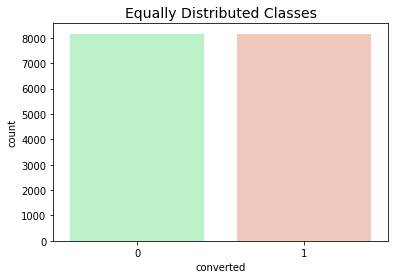

In [22]:
# Equally Distributing and Correlating
print('Distribution of the Classes in the subsample dataset')
print(undersampled_train_data['converted'].mean()) 

sns.countplot('converted', data=undersampled_train_data, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

### Correlation Matrices
Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a visitor is converted. However, it is important that we use the correct dataframe (subsample) in order for us to see which features have a high positive or negative correlation with regards to converted.


**Summary and Explanation:**
- **Negative Correlations:** country_China and new_user are negatively correlated. Notice how the lower these values are, the more likely the end result will be **converted.**
- **Positive Correlations:** total_page_visited is positively correlated. Notice how the higher this value are, the more likely the end result will be **converted.**

**Note:** We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

Text(0.5, 1, 'Heatmap of Correlation - Train set after undersamplin')

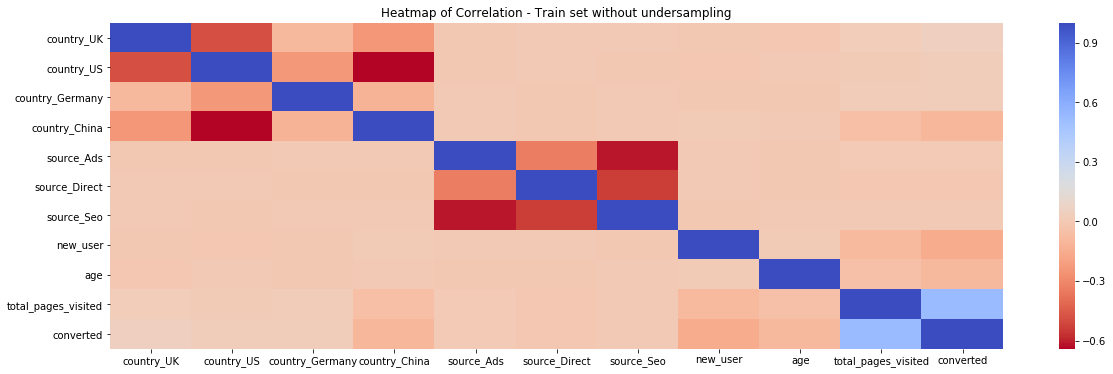

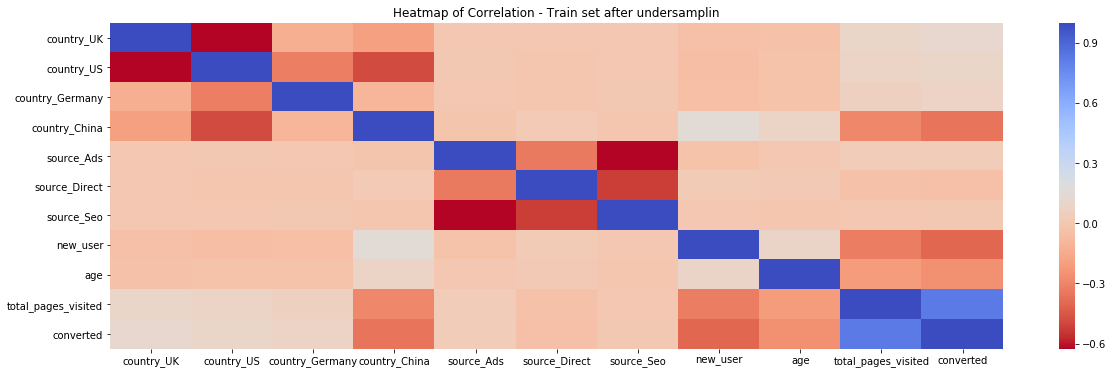

In [86]:
#heatmap
corr = train_data.corr()
plt.figure(figsize=(20,6))
heat = sns.heatmap(data=corr,cmap='coolwarm_r')
plt.title('Heatmap of Correlation - Train set without undersampling')

corr = undersampled_train_data.corr()
plt.figure(figsize=(20,6))
heat = sns.heatmap(data=corr,cmap='coolwarm_r')
plt.title('Heatmap of Correlation - Train set after undersamplin')

### Model evaluation for orginal data

In [69]:
def print_results(headline, true_value, pred):
    print(headline)  
    print("accuracy: {}".format(round(accuracy_score(true_value, pred),2)*100))
    #print("ROC: {}".format(round(roc_auc_score(true_value, pred),2)*100))    
    print("precision: {}".format(round(precision_score(true_value, pred),2)*100))
    print("recall: {}".format(round(recall_score(true_value, pred),2)*100))
    print("f1: {}".format(round(f1_score(true_value, pred),2)*100))

In [88]:
#Cross Validation
## Use GridSearchCV to find the best parameters.
LR_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_LR = GridSearchCV(LogisticRegression(), LR_params)
grid_LR.fit(X_train, Y_train)
## We automatically get the logistic regression with the best parameters.
LR = grid_LR.best_estimator_

# DecisionTree Classifier
TREE_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,5,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_TREE = GridSearchCV(DecisionTreeClassifier(), TREE_params)
grid_TREE.fit(X_train, Y_train)
# tree best estimator
TREE= grid_TREE.best_estimator_

In [89]:
LR_score = cross_val_score(LR, X_train, Y_train, cv=10)
print('Logistic Regression CV Score: ', round(LR_score.mean(), 3) * 100,'%')
TREE_score = cross_val_score(TREE, X_train, Y_train, cv=10)
print('DecisionTree CV Score', round(TREE_score.mean(), 3)* 100,'%')

Logistic Regression CV Score:  98.6 %
DecisionTree CV Score 98.5 %


In [97]:
#testing set
Y_pred_log_reg = log_reg.predict(X_test)
print_results("Logistic Regression:", Y_test, Y_pred_log_reg)
print('-'*20)  
Y_pred_tree = tree_clf.predict(X_test)
print_results("DecisionTree:", Y_test, Y_pred_tree)

Logistic Regression:
accuracy: 99.0
precision: 86.0
recall: 68.0
f1: 76.0
--------------------
DecisionTree:
accuracy: 99.0
precision: 82.0
recall: 69.0
f1: 75.0


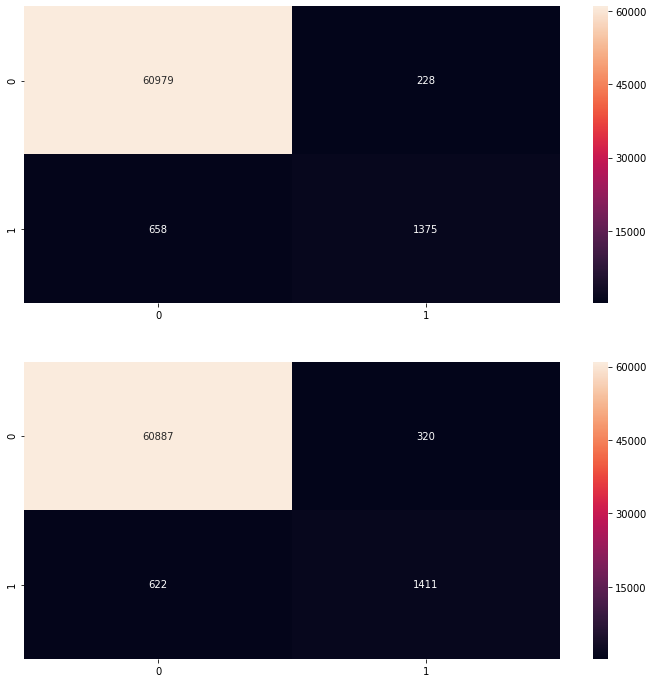

In [91]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
sns.heatmap(confusion_matrix(Y_test,Y_pred_log_reg),annot=True,fmt='2.0f',ax=ax[0])
sns.heatmap(confusion_matrix(Y_test,Y_pred_tree),annot=True,fmt='2.0f',ax=ax[1])

### Model evaluation for data after undersampling

In [92]:
train_x = undersampled_train_data.drop('converted', axis=1)
train_y = undersampled_train_data['converted']
test_x = test_data.drop('converted', axis=1)
test_y = test_data['converted']
#(Lower x y)
train_x = train_x.values
train_y = train_y.values
test_x = test_x.values
test_y = test_y.values

In [93]:
#Cross Validation
## Use GridSearchCV to find the best parameters.
lr_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_lr = GridSearchCV(LogisticRegression(), LR_params)
grid_lr.fit(train_x, train_y)
## We automatically get the logistic regression with the best parameters.
lr = grid_lr.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,5,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(train_x, train_y)
# tree best estimator
tree= grid_tree.best_estimator_

lr_score = cross_val_score(lr, train_x, train_y, cv=10)
print('Logistic Regression CV Score: ', round(lr_score.mean(), 3) * 100,'%')
tree_score = cross_val_score(tree, train_x, train_y, cv=10)
print('DecisionTree CV Score', round(tree_score.mean(), 3)* 100,'%')

Logistic Regression CV Score:  94.0 %
DecisionTree CV Score 93.5 %


In [96]:
#testing set
y_pred_log_reg = lr.predict(test_x)
print_results("Logistic Regression:", test_y, y_pred_log_reg)
print('-'*20)  
y_pred_tree = tree.predict(test_x)
print_results("DecisionTree:", test_y, y_pred_tree)

Logistic Regression:
accuracy: 94.0
precision: 35.0
recall: 94.0
f1: 51.0
--------------------
DecisionTree:
accuracy: 93.0
precision: 32.0
recall: 94.0
f1: 48.0


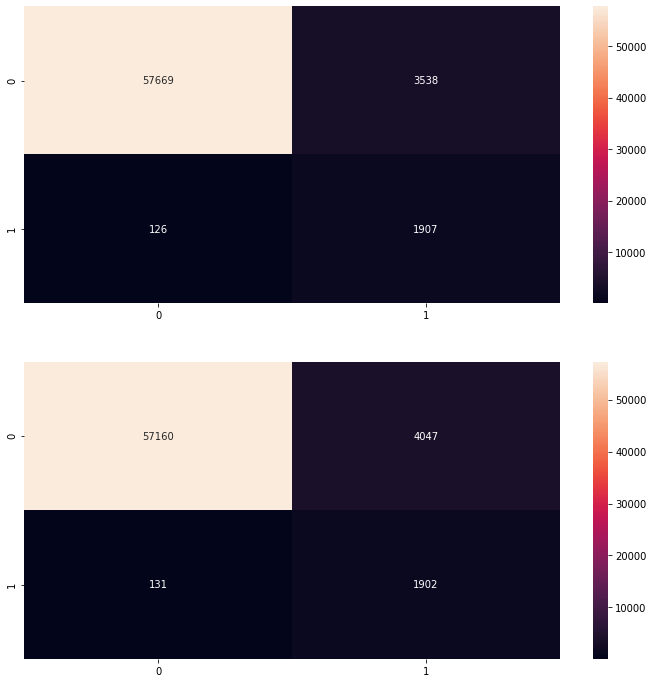

In [98]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
sns.heatmap(confusion_matrix(test_y, y_pred_log_reg),annot=True,fmt='2.0f',ax=ax[0])
sns.heatmap(confusion_matrix(test_y, y_pred_tree),annot=True,fmt='2.0f',ax=ax[1])

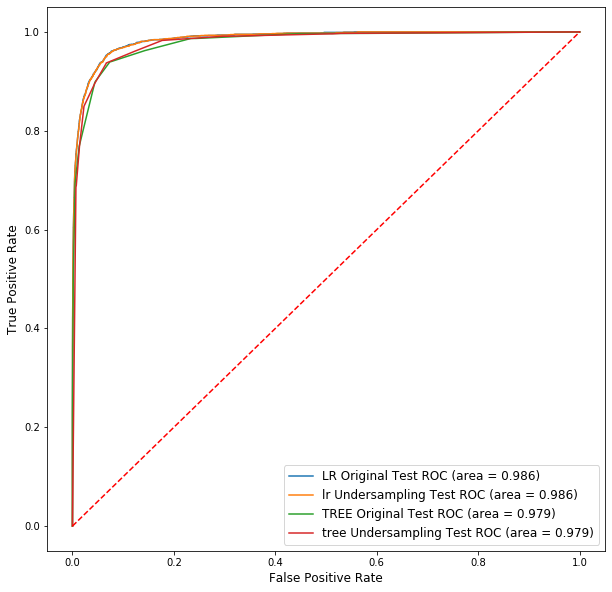

In [105]:
#LR
LR_Y_pred=LR.predict_proba(X_test)[:,1]
LR_test_auc= roc_auc_score(Y_test,LR_Y_pred)
LR_test_fpr, LR_test_tpr,_ = roc_curve(Y_test,LR_Y_pred)

lr_y_pred=lr.predict_proba(test_x)[:,1]
lr_ttauc= roc_auc_score(test_y,lr_y_pred)
lr_tt_fpr, lr_tt_tpr, _ = roc_curve(test_y,lr_y_pred)

#tree
TREE_Y_pred=TREE.predict_proba(X_test)[:,1]
TREE_test_auc= roc_auc_score(Y_test,TREE_Y_pred)
TREE_test_fpr, TREE_test_tpr,_ = roc_curve(Y_test,TREE_Y_pred)

tree_y_pred=tree.predict_proba(test_x)[:,1]
tree_ttauc= roc_auc_score(test_y,tree_y_pred)
tree_tt_fpr, tree_tt_tpr, _ = roc_curve(test_y,tree_y_pred)

plt.figure(figsize=(10,10))
plt.plot(LR_test_fpr, LR_test_tpr, label='LR Original Test ROC (area = %0.3f)'%LR_test_auc)
plt.plot(lr_tt_fpr, lr_tt_tpr, label='lr Undersampling Test ROC (area = %0.3f)'%lr_ttauc)
plt.plot(TREE_test_fpr, TREE_test_tpr, label='TREE Original Test ROC (area = %0.3f)'%TREE_test_auc)
plt.plot(tree_tt_fpr, tree_tt_tpr, label='tree Undersampling Test ROC (area = %0.3f)'%tree_ttauc)
plt.plot([0,1],[0,1],'r--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.legend(fontsize=12)
plt.show()

All result in good AUC, suggesting two classes from all dataset well-separated.

**high recall + low precision :** the class is well detected but the model also include points of other classes in it.

total_pages_visited    21.157098
country_Germany         1.136185
country_UK              0.892071
country_US              0.566459
source_Ads              0.051636
source_Seo              0.035386
source_Direct          -0.092506
new_user               -1.737435
country_China          -2.600201
age                    -4.456390
dtype: float64


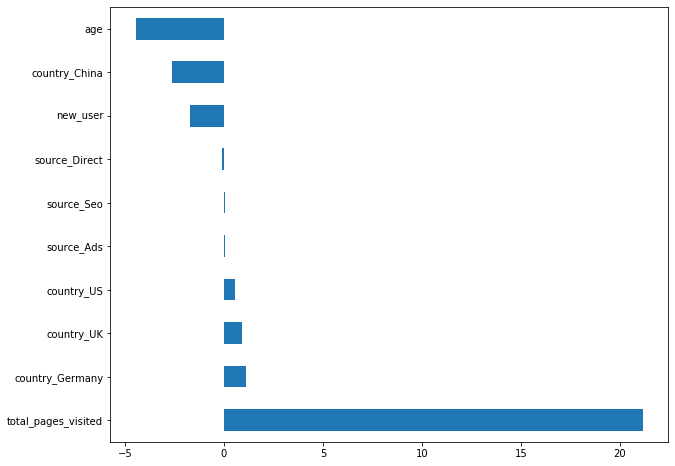

In [127]:
#Let's see what the important coefficients are:
coef_columns = [x for x in X_tn.columns]
varimp=pd.Series(LR.coef_.ravel(),coef_columns).sort_values(ascending=False)
print(varimp)
varimp.plot(kind='barh',figsize=(10,8))

Dropped total_pages_visited: This attribute highly affects the output target. Yet, the total_pages_visited is not known before a user visit a website. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

In [107]:
#drop total_pages_visited
#Splitting the Data (Original DataFrame)  (Capital X Y)
df_nopage=dfd.drop(columns=['total_pages_visited'])
df_nopage.head()

,country_UK,country_US,country_Germany,country_China,source_Ads,source_Direct,source_Seo,new_user,age,converted
0,1,0,0,0,1,0,0,1,0.129032,0
1,0,1,0,0,0,0,1,1,0.096774,0
2,0,1,0,0,0,0,1,1,0.177419,0
3,0,0,0,1,0,0,1,1,0.354839,0
4,0,1,0,0,0,0,1,1,0.209677,0


In [113]:
X_nopage=df_nopage[df_nopage.columns[:-1]]
Y_nopage=df_nopage['converted']
X_nopage_tn, X_nopage_tt, Y_nopage_tn, Y_nopage_tt = train_test_split(X_nopage, Y_nopage, test_size=0.2)
# Turn into an array
X_nopage_train = X_nopage_tn.values
X_nopage_test = X_nopage_tt.values
Y_nopage_train = Y_nopage_tn.values
Y_nopage_test = Y_nopage_tt.values

print(Y_nopage_train.mean(),Y_nopage_test.mean())

0.03227413246467793 0.03216318785578748


In [117]:
train_nopage_data = pd.concat([X_nopage_tn, Y_nopage_tn], axis=1)
test_nopage_data = pd.concat([X_nopage_tt, Y_nopage_tt], axis=1)
Converted = train_nopage_data[train_nopage_data.converted==1]
Not_converted = train_nopage_data[train_nopage_data.converted==0]
print(len(Converted),len(Not_converted))

8164 244794


In [118]:
Not_converted = Not_converted.sample(n=len(Converted))
us_train_data = pd.concat([Converted, Not_converted], axis=0)
us_train_data = us_train_data.sample(frac=1)  #mix order
us_train_data.sample(10)

,country_UK,country_US,country_Germany,country_China,source_Ads,source_Direct,source_Seo,new_user,age,converted
258819,0,1,0,0,1,0,0,0,0.032258,0
178393,0,0,0,1,1,0,0,1,0.161290,0
284581,1,0,0,0,1,0,0,1,0.048387,1
285320,0,1,0,0,0,1,0,1,0.258065,0
49670,0,1,0,0,1,0,0,1,0.161290,1
154224,0,1,0,0,1,0,0,1,0.306452,0
164092,0,1,0,0,0,0,1,0,0.096774,0
253910,0,0,1,0,0,0,1,0,0.177419,1
152402,0,1,0,0,0,0,1,0,0.048387,1
14909,1,0,0,0,0,0,1,0,0.354839,1


In [119]:
tn_x = us_train_data.drop('converted', axis=1)
tn_y = us_train_data['converted']
tt_x = test_nopage_data.drop('converted', axis=1)
tt_y = test_nopage_data['converted']

In [122]:
#Cross Validation
## Use GridSearchCV to find the best parameters.
LR_nopage_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_nopage_LR = GridSearchCV(LogisticRegression(), LR_params)
grid_nopage_LR.fit(tn_x,tn_y)
## We automatically get the logistic regression with the best parameters.
LR_nopage = grid_nopage_LR.best_estimator_

# DecisionTree Classifier
TREE_nopage_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,5,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_nopage_TREE = GridSearchCV(DecisionTreeClassifier(), TREE_nopage_params)
grid_nopage_TREE.fit(tn_x,tn_y)
# tree best estimator
TREE_nopage= grid_nopage_TREE.best_estimator_

lr_nopage_score = cross_val_score(LR_nopage, tn_x, tn_y, cv=10)
print('Logistic Regression CV Score: ', round(lr_nopage_score.mean(), 3) * 100,'%')
tree_nopage_score = cross_val_score(TREE_nopage, tn_x, tn_y, cv=10)
print('DecisionTree CV Score', round(lr_nopage_score.mean(), 3)* 100,'%')

#testing set
y_plg = LR_nopage.predict(tt_x)
print_results("Logistic Regression:", tt_y, y_plg)
print('-'*20)  
y_pt = TREE_nopage.predict(tt_x)
print_results("DecisionTree:", tt_y, y_pt)

Logistic Regression CV Score:  74.0 %
DecisionTree CV Score 74.0 %
Logistic Regression:
accuracy: 73.0
precision: 9.0
recall: 77.0
f1: 16.0
--------------------
DecisionTree:
accuracy: 68.0
precision: 8.0
recall: 81.0
f1: 14.000000000000002


After drop "toal_pages_visited", the model performance is poor is all measurements.

## Results
Here I list the main insights gleaned from my analysis and some associated recommendations.

- **Chinese users are hard to convert.**\
This could be just due to translation or cultural issues. Either way, considering how many potential users are in China I'd recommend the UX department take a look at ways to improve it.
- **German users are relatively easy to convert.**\
Something is going very right with German users and so a little more focus on these users could have a large effect! This could be something for both UX and marketing to look into.
- **Users with an older account are more likely to convert than users with newer accounts.**\
Since they're already in the system, perhaps some targeted emails with offers to bring them back to the site could better capture their conversion potential.
- **Young people are much more likely to convert than older people.**\
UX department may want to look into why people 30+ perform so poorly.
- **Existing marketing channels do not have a significant effect one way or the other.**\
Considering that the site does well with younger users, development of new marketing channels should be done specifically so that they are aimed at reaching younger people.

If a user has visited many pages but hasn't yet converted, they very likely could have a high purchase intent. Perhaps such users could be sent targeted email offers or reminders.